In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision.models import unet

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
path = Path('data/camvid')
path.ls()

[PosixPath('data/camvid/valid.txt'),
 PosixPath('data/camvid/labels'),
 PosixPath('data/camvid/codes.txt'),
 PosixPath('data/camvid/images')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/camvid/images/0016E5_08065.png'),
 PosixPath('data/camvid/images/0006R0_f01500.png'),
 PosixPath('data/camvid/images/0016E5_06510.png')]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/camvid/labels/0006R0_f01770_P.png'),
 PosixPath('data/camvid/labels/0006R0_f01290_P.png'),
 PosixPath('data/camvid/labels/Seq05VD_f02940_P.png')]

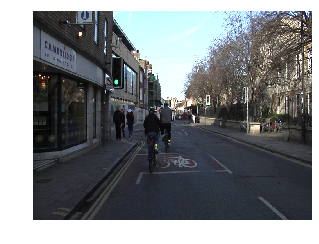

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

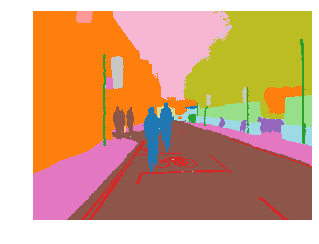

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
mask.shape,mask.data

(torch.Size([1, 720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [ ]:
size=640
bs=4

In [ ]:
data = (ImageFileList.from_folder(path_img)
        .label_from_func(get_y_fn)
        .split_by_fname_file('../valid.txt')
        .datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

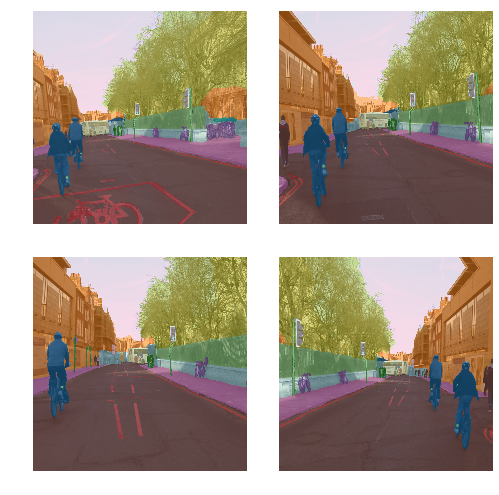

In [ ]:
x,y = data.train_dl.one_batch()
show_xy_images(data.denorm(x.cpu()),y,rows=2, figsize=(7,7))

In [ ]:
x.shape,y.shape

(torch.Size([4, 3, 640, 640]), torch.Size([4, 1, 640, 640]))

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze()
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


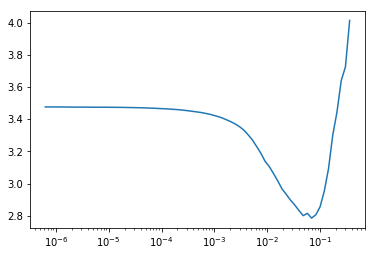

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

Total time: 00:43
epoch  train_loss  valid_loss  acc_camvid
1      0.738934    1.580469    0.615568    (00:08)
2      0.686228    2.251218    0.784224    (00:08)
3      0.621054    0.796167    0.805764    (00:08)
4      0.546024    0.401186    0.891821    (00:08)
5      0.490819    0.372504    0.899112    (00:08)



In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

In [ ]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


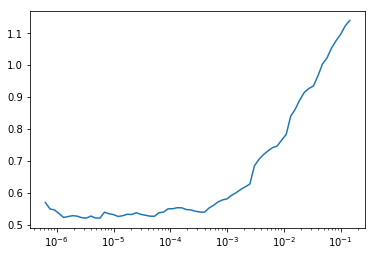

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, slice(1e-5,lr/5))

Total time: 06:36
epoch  train_loss  valid_loss  acc_camvid
1      0.530427    0.484830    0.864151    (00:32)
2      0.525674    0.511068    0.853150    (00:32)
3      0.511834    0.477144    0.862369    (00:32)
4      0.528267    0.543512    0.841778    (00:32)
5      0.511065    0.471541    0.868909    (00:33)
6      0.480037    0.438459    0.874060    (00:33)
7      0.451626    0.426736    0.866344    (00:33)
8      0.432813    0.440977    0.864333    (00:33)
9      0.405681    0.419813    0.871764    (00:33)
10     0.402044    0.398860    0.875411    (00:33)
11     0.395874    0.399895    0.873712    (00:33)
12     0.386090    0.390450    0.877115    (00:33)



In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2')

In [ ]:
learn.fit_one_cycle(24, slice(1e-5,lr/15))

Total time: 13:19
epoch  train_loss  valid_loss  acc_camvid
1      0.383217    0.400518    0.873367    (00:32)
2      0.378356    0.391630    0.876220    (00:32)
3      0.383303    0.399066    0.872713    (00:32)
4      0.374031    0.406957    0.866100    (00:32)
5      0.376649    0.388265    0.878963    (00:32)
6      0.393576    0.404801    0.873408    (00:32)
7      0.388583    0.429938    0.870969    (00:33)
8      0.375938    0.413643    0.871897    (00:33)
9      0.373913    0.394423    0.880378    (00:33)
10     0.376665    0.371560    0.885814    (00:33)
11     0.370423    0.392219    0.884953    (00:33)
12     0.351648    0.379200    0.883355    (00:33)
13     0.335984    0.378465    0.887384    (00:33)
14     0.331265    0.352171    0.890332    (00:33)
15     0.320323    0.349380    0.894584    (00:33)
16     0.315860    0.350345    0.894189    (00:33)
17     0.306006    0.343455    0.898246    (00:33)
18     0.297947    0.345338    0.899927    (00:33)
19     0.288271    0.3

In [ ]:
learn.save('stage-3')

In [ ]:
learn.fit_one_cycle(12, slice(1e-6,lr/50), wd=1e-6)

Total time: 06:40
epoch  train_loss  valid_loss  acc_camvid
1      0.284816    0.344045    0.899272    (00:32)
2      0.282977    0.347544    0.897939    (00:32)
3      0.290330    0.352020    0.897585    (00:33)
4      0.290030    0.354229    0.897178    (00:33)
5      0.281001    0.350257    0.900196    (00:33)
6      0.283560    0.340642    0.903430    (00:33)
7      0.282009    0.352506    0.902126    (00:33)
8      0.276900    0.339362    0.903946    (00:33)
9      0.274030    0.344644    0.903844    (00:33)
10     0.272405    0.341871    0.902852    (00:33)
11     0.273903    0.340983    0.903603    (00:33)
12     0.272666    0.342795    0.902999    (00:33)

